In [1]:
# Instalar dependencias
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install joblib
!pip install scipy
# !pip install nbstripout
# !pip install jupytext

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline
from IPython.display import Markdown as md, display



In [3]:
word_data = pd.read_csv("words_ux.csv")

word_data.head()

,Words
0,Boring Consistent EasyToUse Fast Simple Useful
1,Boring Confusing Contradictory Difficult EasyT...
2,Confusing Fast Old Unattractive Useful
3,Complex Confusing Creative Difficult
4,Advanced Clean Credible Difficult Effective New


In [4]:
word_data.info()
word_data.describe()
print(f"Total registros: {len(word_data):,}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Words   52 non-null     object
dtypes: object(1)
memory usage: 548.0+ bytes


,Words
count,52
unique,52
top,Boring Consistent EasyToUse Fast Simple Useful
freq,1


Total registros: 52


In [5]:
# Separar las palabras por fila
word_list = []

for row in word_data["Words"]:
    if pd.notna(row):
        words = row.split()
        word_list.extend(words)

# Crear nuevo DataFrame con una sola columna
clean_df = pd.DataFrame(word_list, columns=["Words"])

# Mostrar las primeras filas
print(clean_df.head())

        Words
0      Boring
1  Consistent
2   EasyToUse
3        Fast
4      Simple


In [6]:
# Eliminar duplicados
clean_df_unique = clean_df.drop_duplicates()

# Mostrar las primeras filas del resultado
print(clean_df_unique)

              Words
0            Boring
1        Consistent
2         EasyToUse
3              Fast
4            Simple
..              ...
337   Sophisticated
342  SystemOriented
345   Unpredictable
356        Engaging
379     Distracting

[84 rows x 1 columns]


In [7]:
duplicados = clean_df_unique[clean_df_unique.duplicated()]
if duplicados.empty:
    print("✅ No hay palabras duplicadas.")
else:
    print("⚠️ Se encontraron palabras duplicadas:")
    print(duplicados)


✅ No hay palabras duplicadas.


## Construcción de la Document-Term Matrix (DTM)

### Definición

Una DTM es una matriz matemática que organiza los datos de un conjunto de documentos de la siguiente manera:

- Filas: Representan cada documento individual de la colección (corpus).

- Columnas: Representan los términos únicos (palabras) que aparecen en el conjunto completo de documentos.

- Celdas (Valores): Contienen un valor numérico que indica la frecuencia o importancia de un término particular en un documento específico

### Objetivo

Su objetivo pricipal es transformar datos de texto no estructurados en un formato numérico estructurado que pueda ser analizado por algoritmos de aprendizaje automático (Machine Learning) y métodos estadísticos.



Persona 2: Construcción de la Document-Term Matrix (DTM) (20%)
Responsabilidad principal: Transformar los datos en una matriz binaria usable.

Tareas específicas:

Usar sklearn.feature_extraction.text.CountVectorizer(binary=True) o manualmente con pandas.
Construir la DTM binaria (1 si la palabra está, 0 si no).
Mostrar un fragmento de la matriz (ej. dtm.head()).
Guardar lista de palabras únicas (vocabulary).
Explicar por qué usamos binario (presencia/ausencia).

### Paso 1: Generación de la DTM Binaria

Se utiliza el *DataFrame* `clean_df_unique` para constuir la *DTM*. Cada palabra en el *DataFrame* se considerará como un "documento" de una sola palabra para el propósito de esta transformación. 

In [8]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(binary=True)

dtm_sparse = vectorizer.fit_transform(clean_df_unique['Words'])

# Convertir la matriz dispersa (sparse) a un DataFrame para una mejor visualización
dtm = pd.DataFrame(
    dtm_sparse.toarray(),
    columns=vectorizer.get_feature_names_out()
)

# Se muestra un fragmento de la matriz
print("### Document-Term Matrix (DTM) Binaria (Fragmento) ###")
print(dtm.head())

# Se guarda la lista de palabras únicas (vocabulary)
vocabulary = vectorizer.get_feature_names_out()
print(f"\n### Vocabulario (Palabras Únicas) ###")
print(f"Total de palabras en el vocabulario: {len(vocabulary)}")
print(vocabulary[:5]) # Se muestran las primeras 5 palabras

### Document-Term Matrix (DTM) Binaria (Fragmento) ###
   advanced  ambiguous  attractive  boring  bright  busy  clean  clear  \
0         0          0           0       1       0     0      0      0   
1         0          0           0       0       0     0      0      0   
2         0          0           0       0       0     0      0      0   
3         0          0           0       0       0     0      0      0   
4         0          0           0       0       0     0      0      0   

   complex  comprehensive  ...  trustworthy  unattractive  unconventional  \
0        0              0  ...            0             0               0   
1        0              0  ...            0             0               0   
2        0              0  ...            0             0               0   
3        0              0  ...            0             0               0   
4        0              0  ...            0             0               0   

   understandable  unpredictable  unr

### Paso 2: Medidas de Similitud

Se calcularon dos matrices de similitud a partir de la DTM: Cosine Similarity, que mide el ángulo entre vectores para identificar patrones de aparición similares entre palabras, y Jaccard Similarity, que evalúa la proporción de coincidencias binarias entre conjuntos. Ambas matrices se transformaron en DataFrames para facilitar su interpretación y se visualizaron mediante heatmaps, permitiendo observar las relaciones más estrechas entre términos del vocabulario.

=== Similitud del Coseno (fragmento) ===


,0,1,2,3,4,5,6,7,8,9
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0



=== Similitud de Jaccard (fragmento) ===


,0,1,2,3,4,5,6,7,8,9
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Heatmap - Similitud del Coseno (primeras 10 palabras)')

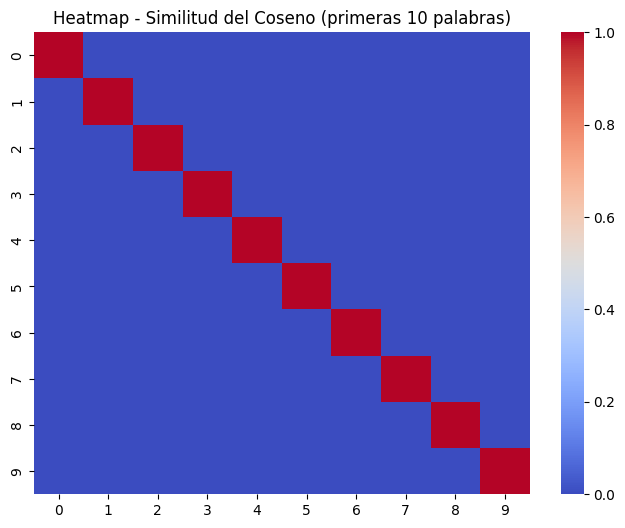

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Heatmap - Similitud de Jaccard (primeras 10 palabras)')

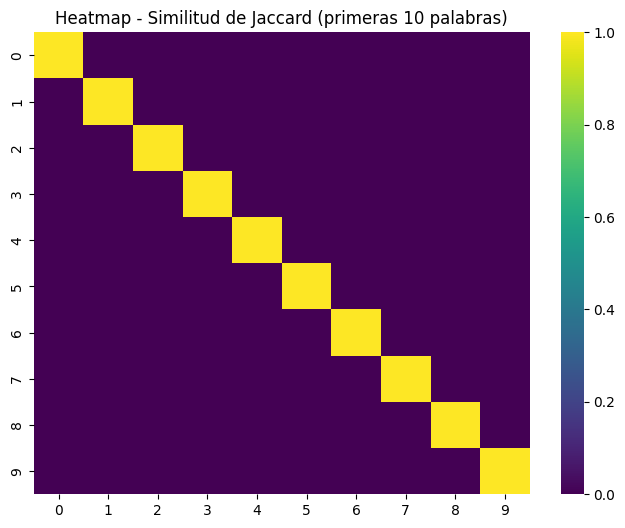


### Teoría de las Medidas de Similitud

#### 1. Similitud del Coseno

Mide el **ángulo entre dos vectores** en un espacio n-dimensional.  
Cuanto menor sea el ángulo, mayor la similitud.  
Se define como:

\[
\text{Similitud}_{\cos}(A, B) = \frac{A \cdot B}{\|A\| \|B\|}
\]

- Toma valores entre 0 y 1 (si los vectores son no negativos).  
- 1 indica vectores idénticos.  
- Muy usada en modelos de texto, embeddings y análisis semántico.

---

#### 2. Similitud de Jaccard

Evalúa la **intersección sobre la unión** de los conjuntos de características activas (1’s):

\[
\text{Similitud}_{J}(A, B) = \frac{|A \cap B|}{|A \cup B|}
\]

- Toma valores entre 0 y 1.  
- Útil para comparar representaciones binarias (presencia/ausencia de palabras).  
- 1 significa que ambos vectores tienen los mismos elementos activos.


In [16]:
# 1. Convertir DTM a matriz NumPy (requerido por sklearn)
from sklearn.metrics import pairwise_distances


dtm_array = dtm.values  # <--- CORRECCIÓN CLAVE
indices = dtm.index if isinstance(dtm.index, pd.Index) else range(len(dtm))

# 2. Matriz de similitud del Coseno
cosine_sim_matrix = cosine_similarity(dtm_array)

# 3. Matriz de similitud de Jaccard
#    (pairwise_distances devuelve distancias, así que restamos a 1)
jaccard_dist_matrix = pairwise_distances(dtm_array, metric="jaccard")
jaccard_sim_matrix = 1 - jaccard_dist_matrix

# 4. Convertir a DataFrames con nombres de las palabras como índices
cosine_df = pd.DataFrame(cosine_sim_matrix, index=indices, columns=indices)
jaccard_df = pd.DataFrame(jaccard_sim_matrix, index=indices, columns=indices)

# 5. Mostrar fragmentos de ambas matrices
print("=== Similitud del Coseno (fragmento) ===")
display(cosine_df.iloc[:10, :10])

print("\n=== Similitud de Jaccard (fragmento) ===")
display(jaccard_df.iloc[:10, :10])

# 6. Visualizar con Heatmaps
plt.figure(figsize=(8, 6))
sns.heatmap(cosine_df.iloc[:10, :10], cmap="coolwarm", annot=False)
plt.title("Heatmap - Similitud del Coseno (primeras 10 palabras)")
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(jaccard_df.iloc[:10, :10], cmap="viridis", annot=False)
plt.title("Heatmap - Similitud de Jaccard (primeras 10 palabras)")
plt.show()

# 7. Explicación Teórica
display(md(r"""
### Teoría de las Medidas de Similitud

#### 1. Similitud del Coseno

Mide el **ángulo entre dos vectores** en un espacio n-dimensional.  
Cuanto menor sea el ángulo, mayor la similitud.  
Se define como:

\[
\text{Similitud}_{\cos}(A, B) = \frac{A \cdot B}{\|A\| \|B\|}
\]

- Toma valores entre 0 y 1 (si los vectores son no negativos).  
- 1 indica vectores idénticos.  
- Muy usada en modelos de texto, embeddings y análisis semántico.

---

#### 2. Similitud de Jaccard

Evalúa la **intersección sobre la unión** de los conjuntos de características activas (1’s):

\[
\text{Similitud}_{J}(A, B) = \frac{|A \cap B|}{|A \cup B|}
\]

- Toma valores entre 0 y 1.  
- Útil para comparar representaciones binarias (presencia/ausencia de palabras).  
- 1 significa que ambos vectores tienen los mismos elementos activos.
"""))
